In [ ]:
Sweepfinder 
https://degiorgiogroup.fau.edu/Manual_SweepFinder2_v1.0.pdf

needs: 
#readsnps: infile should have columns named position, x, and n (and optionally folded


In [2]:
import pandas as pd
import glob

In [ ]:

# Load the raw genotype data
with open("raw_genotypes.txt") as f:
    lines = [line.strip().split() for line in f]

# Parse into DataFrame
records = []
for line in lines:
    chrom, pos, ref, alt, *gts = line
    pos = int(pos)
    # Count 0s and 1s from genotypes
    derived_count = 0
    total_alleles = 0
    for gt in gts:
        if "|" in gt:
            alleles = gt.split("|")
        else:
            alleles = gt.split("/")
        if "." in alleles:
            continue
        derived_count += alleles.count("1")
        total_alleles += len(alleles)
    # Only keep if there's full data
    if total_alleles > 0:
        records.append([chrom, pos, derived_count, total_alleles])

# Convert to DataFrame and preview
sf2_df = pd.DataFrame(records, columns=["chrom", "pos", "derived", "sample_size"])


In [39]:
sf2_df.to_csv("modern.sf", sep="\t", index=False, header=False)

In [52]:
neutral = sf2_df[['pos', 'derived', 'sample_size']]

In [54]:
neutral.columns = ['position', 'x', 'n']

In [56]:
neutral.to_csv("modern_all_chrom.tsv", sep="\t", index=False)

In [75]:
saved_files = []
for chrom, group in sf2_df.groupby("chrom"):
    group_sorted = group.sort_values("pos")
    output_file = f"sweepfinder2_chr{chrom}.sf"
    
    group_sorted = group_sorted[["pos", "derived", "sample_size"]]
    group_sorted.columns = ["position", "x", "n"]
    group_sorted.to_csv(
        output_file, sep="\t", index=False
    )
    saved_files.append(output_file)

saved_files

['sweepfinder2_chr1.sf',
 'sweepfinder2_chr2.sf',
 'sweepfinder2_chr3.sf',
 'sweepfinder2_chr4.sf',
 'sweepfinder2_chr5.sf']

In [43]:
## check that it saved correctly 
pd.read_csv('sweepfinder2_chr5.sf', sep = '\t'bb)

,70,0,378
0,75,0,378
1,102,0,378
2,116,0,378
3,135,6,378
4,140,2,378
...,...,...,...
330909,26790491,2,378
330910,26790492,2,378
330911,26790553,0,378
330912,26790733,4,378


In [ ]:
# Step 1: Generate the empirical background SFS from your data.
SweepFinder2/SweepFinder2 -f modern_all_chrom.tsv genomewide.spect


## from the manual 
./SweepFinder2 –f CombinedFreqFile SpectFile

In [ ]:
SweepFinder2/SweepFinder2 -l 100 modern_all_chrom.tsv genomewide.spect sweepfinder_output.sf2


In [ ]:
SweepFinder2/SweepFinder2 -l 100 modern_all_chrom.tsv genomewide.spect sweepfinder_output.sf2

In [59]:
pd.read_csv('sweepfinder_output.sf2', sep = '\t')

,location,LR,alpha
0,7.000000e+01,2.298214,0.080999
1,3.051863e+04,0.000000,1.246543
2,6.096725e+04,0.000000,0.205997
3,9.141588e+04,0.000000,0.603626
4,1.218645e+05,0.000000,7.965450
...,...,...,...
93,2.831792e+06,0.000000,0.390578
94,2.862241e+06,0.047026,0.214523
95,2.892690e+06,0.000000,1.416687
96,2.923138e+06,0.000000,0.221581


In [116]:
import subprocess
import datetime

In [118]:


# now launch all teh chromosomes 
sbatch_path = "/carnegie/nobackup/scratch/tbellagio/selection_scan/sweepfinder/"
batch_script_list = []

# Timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# SweepFinder2-specific version with a predificned neutral sfs and run every 1000 snps
for chr_num in range(1, 6):
    sbatch_filename = f"sbatch_sweepfinder2_chr{chr_num}.sh"
    log_filename = f"{sbatch_path}/sweepfinder2_chr{chr_num}_{timestamp}_output.txt"
    
    sbatch_command = f"""#!/bin/bash
#SBATCH --job-name="sf2_chr{chr_num}"
#SBATCH --time=48:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=32G
#SBATCH --output={log_filename}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd {sbatch_path}
pwd

echo "Running SweepFinder2 on chromosome {chr_num}..."

/home/tbellagio/SweepFinder2/SweepFinder2 -sg 100 sweepfinder2_chr{chr_num}.sf sweepfinder_chr{chr_num}_100w_nback.out
"""

    # Save batch script
    with open(sbatch_filename, 'w') as f:
        f.write(sbatch_command)

    batch_script_list.append(sbatch_filename)


In [ ]:
## putting or not teh neutral base don the whole genome didnt change anything 
SweepFinder2/SweepFinder2 -sg 1000 sweepfinder2_chr{chr_num}.sf sweepfinder_chr{chr_num}_1000w_nback.sf2

In [119]:
for i in range(len(batch_script_list)):
    subprocess.run(['sbatch', batch_script_list[i]])

Submitted batch job 68548
Submitted batch job 68549
Submitted batch job 68550
Submitted batch job 68551
Submitted batch job 68552


In [ ]:
# this is the most basic way to run sweepfinder
SweepFinder2 -l <grid_spacing> <SNP_file.sf> <spectrum_file> <output_file>


In [ ]:
## other way is to incorporate recombination maps 
SweepFinder2 -lr <grid_spacing> <SNP_file.sf> <spectrum_file> <recomb_file> <output_file>


In [4]:
import pandas as pd
import glob

# List all SweepFinder2 output files
files = sorted(glob.glob("sweepfinder_chr*100w_nback.sf2"))

In [26]:
# sweepfinder_chr1_100w_nback.out

files = sorted(glob.glob("sweepfinder_chr*_100w_nback.out"))

In [27]:
files

['sweepfinder_chr1_100w_nback.out',
 'sweepfinder_chr2_100w_nback.out',
 'sweepfinder_chr3_100w_nback.out',
 'sweepfinder_chr4_100w_nback.out',
 'sweepfinder_chr5_100w_nback.out']

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load gene table ===
genes_df = pd.read_csv('../genes_df.csv')

# === Load and concatenate SweepFinder2 results ===
chroms = ['1', '2', '3', '4', '5']
sweep_all = []
offset = 0
chrom_lengths = {}

for chrom in chroms:
    
    df = pd.read_csv(f'sweepfinder_chr{chrom}_100w_nback.out', sep='\t')
    df.columns = ['location', 'LR', 'alpha']
    df['chrom'] = chrom
    df['pos_cum'] = df['location'] + offset

    chrom_len = df['location'].max()
    chrom_lengths[chrom] = chrom_len
    offset += chrom_len

    sweep_all.append(df)


In [11]:
sweep_df = pd.concat(sweep_all, ignore_index=True)

In [12]:
sweep_df['chrom'] = sweep_df['chrom'].astype(int)

In [13]:
sweep_df

,location,LR,alpha,chrom,pos_cum
0,3.320000e+02,0.000000,1200.000000,1,3.320000e+02
1,4.320004e+02,0.000000,0.324321,1,4.320004e+02
2,5.320008e+02,0.000000,1.500144,1,5.320008e+02
3,6.320011e+02,0.000346,0.098777,1,6.320011e+02
4,7.320015e+02,0.000000,5.995429,1,7.320015e+02
...,...,...,...,...,...
1188771,2.679039e+07,0.000000,0.922945,5,1.189502e+08
1188772,2.679049e+07,0.000000,4.001868,5,1.189503e+08
1188773,2.679059e+07,0.001563,0.067780,5,1.189504e+08
1188774,2.679069e+07,0.000000,0.315786,5,1.189505e+08


In [14]:
sweep_df['chrom'].unique()

array([1, 2, 3, 4, 5])

In [19]:
df = sweep_df.copy()

In [20]:
genes_df = pd.read_csv('../genes_df.csv')


In [16]:
#sweep_df.to_csv('sweep_df_results100w_nb.csv',index=None)

1
2
2
3
4
5


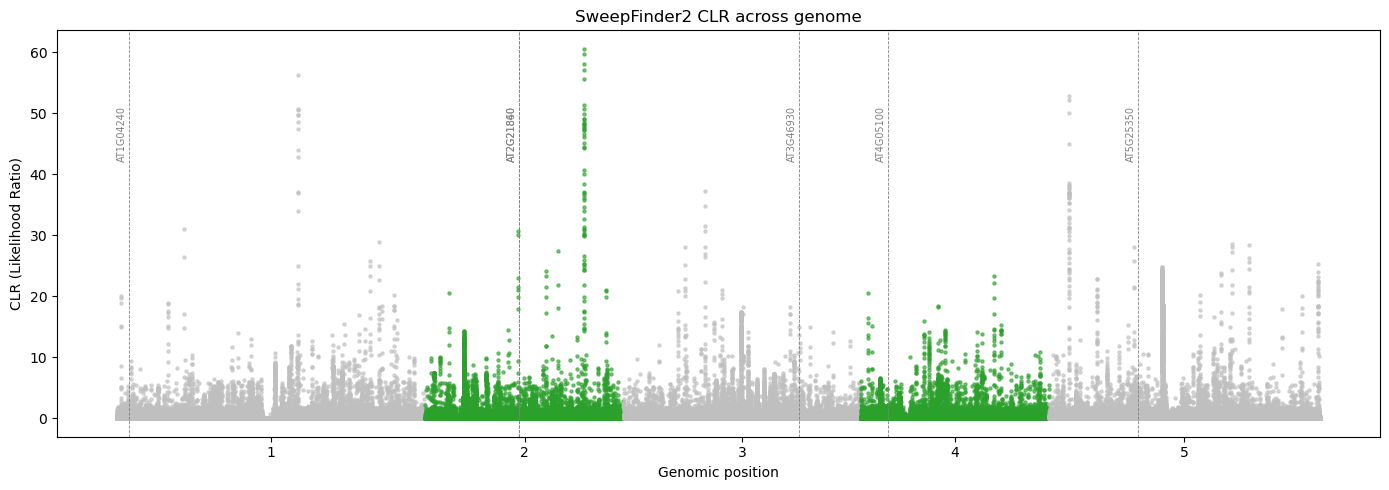

In [ ]:

plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['LR'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {chrom}')

# X-axis ticks by chromosome midpoint
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.xlabel('Genomic position')
plt.ylabel('CLR (Likelihood Ratio)')
plt.title('SweepFinder2 CLR across genome')
plt.tight_layout()

# === Annotate gene positions ===

for _, row in genes_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    # Compute gene center
    gene_center = (gene_start + gene_ends) // 2

    # Subset df by chromosome
    subset = df[df['chrom'] == chrom]

    # Find the nearest position to the gene center
    nearest_idx = (subset['location'] - gene_center).abs().idxmin()
    gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']

    # Plot vertical line at gene
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['LR'].max() * 0.7, gene_id,
             rotation=90, fontsize=7, color='grey', ha='center')

plt.show()


In [25]:
region_df

,location,LR,alpha,chrom,pos_cum
1007811,8.694311e+06,0.0,0.724396,5,1.008541e+08
1007812,8.694411e+06,0.0,0.405872,5,1.008542e+08
1007813,8.694511e+06,0.0,3.364675,5,1.008543e+08
1007814,8.694611e+06,0.0,0.237309,5,1.008544e+08
1007815,8.694711e+06,0.0,0.276290,5,1.008545e+08
...,...,...,...,...,...
1009837,8.896912e+06,0.0,0.028605,5,1.010567e+08
1009838,8.897012e+06,0.0,0.023099,5,1.010568e+08
1009839,8.897112e+06,0.0,0.019370,5,1.010569e+08
1009840,8.897212e+06,0.0,0.016678,5,1.010570e+08


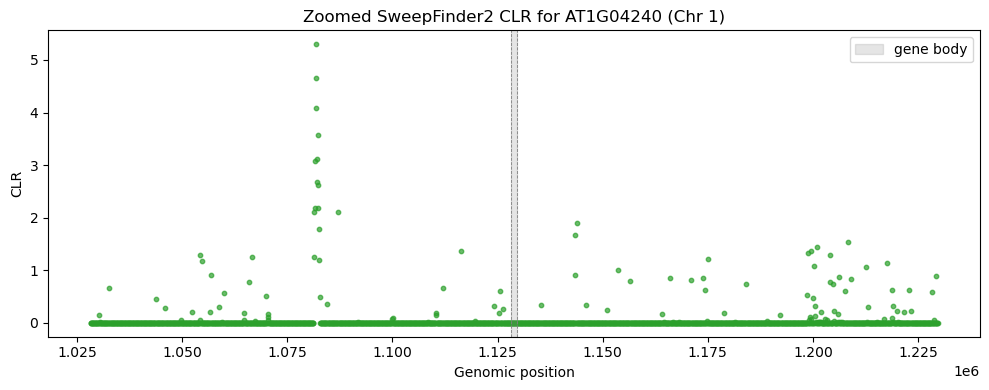

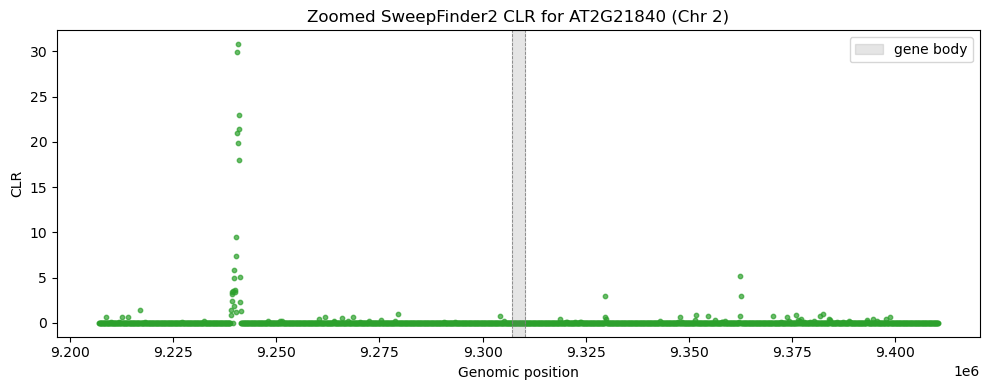

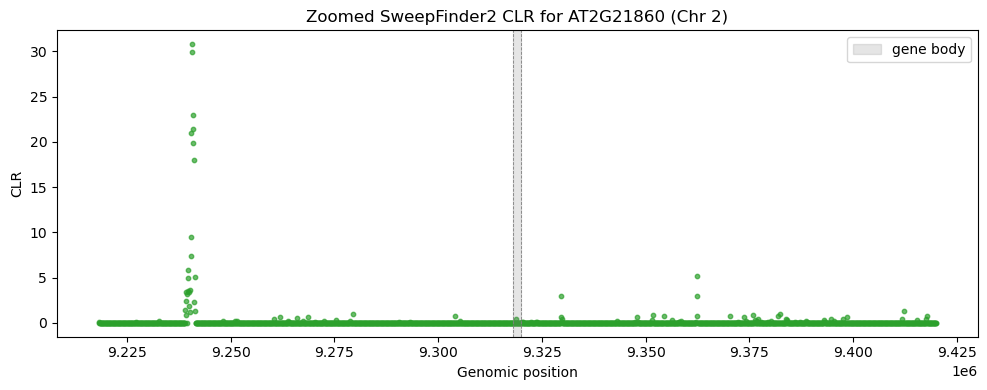

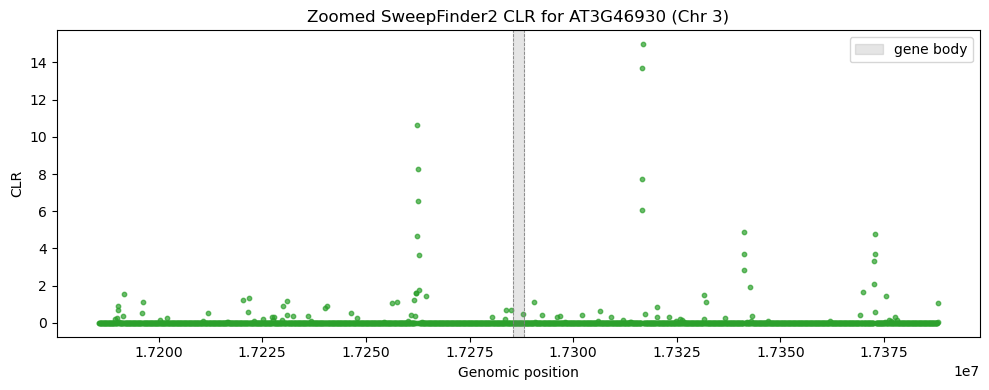

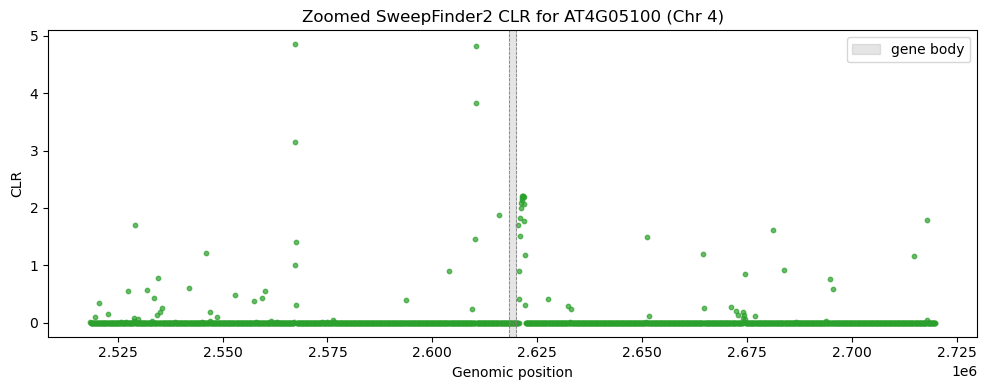

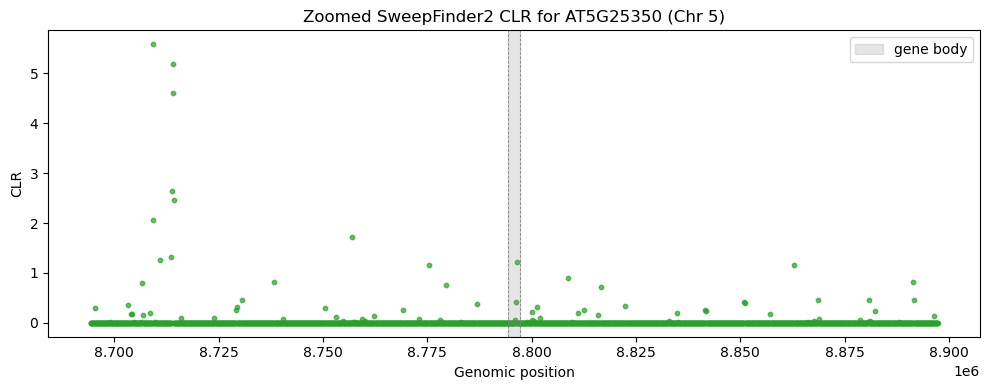

In [ ]:
import matplotlib.pyplot as plt

for _, row in genes_df.iterrows():
    chrom = row['chrom']  # Make sure it's a string to match `sweep_df`
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']

    # Subset region ±100 kb around the gene
    region_df = sweep_df[
        (sweep_df['chrom'] == chrom) &
        (sweep_df['location'] >= gene_start - 100_000) &
        (sweep_df['location'] <= gene_end + 100_000)
    ]

    if region_df.empty:
        continue  # Skip if no data in the region

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(region_df['location'], region_df['LR'], s=10, alpha=0.7, color='#2ca02c')

    # Gene body highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Labels
    plt.title(f'Zoomed SweepFinder2 CLR for {gene_id} (Chr {chrom})')
    plt.xlabel('Genomic position')
    plt.ylabel('CLR')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
## create a recombination map from the genetic and phisical map?
import os
# Load your genetic map (example columns: pos_bp, cM)
genmap = pd.read_csv("../selection_scan/genetic_map.csv")

genmap = genmap.sort_values(by=["chr", "bp"]).reset_index(drop=True)

# Convert cM to Morgans
genmap["morgan"] = genmap["cM"] / 100.0

# Compute recombination rate per base pair per chromosome
def compute_recomb_rate(df):
    df = df.sort_values("bp").copy()
    df["recomb_rate"] = df["morgan"].diff() / df["bp"].diff()
    df.iloc[0, df.columns.get_loc("recomb_rate")] = 0  # First entry has no prior
    return df

genmap_rates = genmap.groupby("chr").apply(compute_recomb_rate).reset_index(drop=True)

# Filter out negative or NaN recombination rates
genmap_rates = genmap_rates[genmap_rates["recomb_rate"] >= 0]


genmap_rates['recomb_rate'].describe()

genmap_rates[genmap_rates['recomb_rate']!=0]['recomb_rate'].describe()
genmap_rates.iloc[1:, :]['recomb_rate'].describe()


# Compute recombination rate in cM/Mb
genmap['recomb_rate'] = genmap['cM'].diff() / genmap['bp'].diff()

# Optional: convert to Morgans per bp
genmap['recomb_rate_morgan'] = genmap['recomb_rate'] * 0.01

# Drop first row (NaN from diff)
genmap = genmap.dropna()

# Save for SweepFinder2 (position + recombination rate per bp)
genmap[['bp', 'recomb_rate_morgan']]#.to_csv("chr1_rec_map.tsv", sep="\t", index=False, header=False)
